In [1]:
from utils import predict_transform, write_results
from dataset import corners_to_centre_dims
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [102]:
def loss(pred, label):
    # constants
    LAMBDA_CLASS = 1
    LAMBDA_NOOBJ = 5
    LAMBDA_BOX = 5
    LAMBDA_OBJ = 1

    # losses
    bce = nn.BCELoss()
    mse = nn.MSELoss()
    ce = nn.CrossEntropyLoss()

    # TODO: check CUDA

    # [x_c, y_c, w, h, Pr(obj), c...]

    # create identity function masks 
    objs = (label[...,4] == 1)
    njs = (label[...,4] == 0)

    # no obj loss
    no_object_loss = bce(
        (pred[..., 4][njs].float()), (label[..., 4][njs].float())
    )

    # obj loss
    object_loss = bce(
        (pred[..., 4][objs].float()), (label[..., 4][objs].float()),
    )

    # bbox loss
    bbox_loss = mse(
        torch.sqrt(pred[..., 0:4][objs]), torch.sqrt(label[..., 0:4][objs])
    )

    # class loss
    cls_argmaxs = torch.argmax(label[..., 5:], dim=-1)
    class_loss = ce(
        (pred[..., 5:][objs]), (cls_argmaxs[objs])
    )

    loss = no_object_loss + object_loss + bbox_loss + class_loss
    loss_const = LAMBDA_NOOBJ*no_object_loss + LAMBDA_OBJ*object_loss + LAMBDA_BOX*bbox_loss + LAMBDA_CLASS*class_loss

    return loss, loss_const

In [4]:
pred = torch.load("ex_tensors/yolo_layer_output_size10647.pt")
pred.shape

torch.Size([1, 10647, 85])

In [21]:
target = torch.tensor([
    [25, 25, 50, 50, 1, 0, 0, 1], 
    [0, 0, 0, 0, 0, 0, 0, 0],
    [50, 50, 50, 50, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]]) # 2x2 gridsize [obj, xc, yc, w, h, cls...]

good_pred = torch.tensor([
    [24, 26.5, 48, 47, 0.9, 0.01, 0.01, 0.98], 
    [0, 0, 0, 0, 0.2, 0, 0, 0],
    [51, 52, 49, 51, 0.97, 0.02, 0.98, 0],
    [0, 0, 0, 0, 0.1, 0, 0, 0]])

bad_pred = torch.tensor([
    [2, 265, 8, 27, 0.2, 0.3, 0.5, 0.2],
    [0, 0, 0, 0, 0.9, 0, 0, 0],
    [50, 2, 492, 81, 0.1, 0.7, 0.2, 0.1], 
    [0, 0, 0, 0, 0.97, 0, 0, 0]]) 

good_preds = torch.cat((good_pred, good_pred)).reshape(2, 4, -1)
bad_preds = torch.cat((bad_pred, bad_pred)).reshape(2, 4, -1)
avg_preds = torch.cat((bad_pred, good_pred)).reshape(2, 4, -1)
targets = torch.cat((target, target)).reshape(2, 4, -1)

objs = (targets[...,4] == 1)
njs = (targets[...,4] == 0)

In [98]:
fake_target = torch.zeros(1, 10647, 85)
fake_target[...,0:4] = torch.randint(0, 416, (10647,4))
fake_target[...,4] = torch.randint(0, 2, (10647,))
fake_target[...,5] = 1

In [92]:
torch.min(pred[...,3])

tensor(0.3586)

In [103]:
loss(pred, fake_target)

(tensor(92.6222), tensor(380.3016))

In [33]:
good_loss, good_loss_c = loss(good_preds, targets)
avg_loss, avg_loss_c = loss(avg_preds, targets)
bad_loss, bad_loss_c = loss(bad_preds, targets)

print(f"good losses: {good_loss:.3f}      {good_loss_c:.3f}")
print(f"avg losses:  {avg_loss:.3f}     {avg_loss_c:.3f}")
print(f"bad losses:  {bad_loss:.3f}     {bad_loss_c:.3f}")

good losses: 0.813      1.537
avg losses:  30.065     142.640
bad losses:  59.317     283.744


In [96]:
pred[0][2][0:2]

tensor([21.2441, 12.5748])

In [94]:
torch.max(pred[0][...,4])

tensor(0.9998)

In [79]:
one_percentile = pred[0][pred[...,-80].sum(dim=0) > 0.99]

Text(0, 0.5, 'Logit Value')

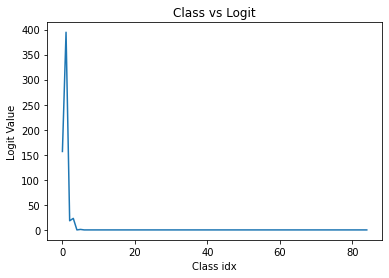

In [88]:
plt.plot(np.arange(one_percentile.shape[-1]), one_percentile[-1])
plt.title("Class vs Logit")
plt.xlabel("Class idx")
plt.ylabel("Logit Value")

In [82]:
one_percentile[0]

tensor([6.6916e+00, 3.9126e+02, 3.7888e+01, 1.8850e+02, 6.2786e-07, 9.9970e-01,
        1.8154e-05, 1.6480e-04, 1.3782e-05, 2.9437e-05, 6.2725e-05, 7.0992e-05,
        2.7664e-04, 1.9702e-04, 6.5756e-06, 9.3093e-05, 3.1154e-05, 4.4967e-06,
        6.5017e-04, 4.6819e-05, 3.3273e-05, 7.3997e-05, 3.4493e-05, 2.1810e-05,
        2.2238e-05, 4.2626e-05, 1.0121e-04, 1.5352e-06, 4.2063e-05, 3.8136e-07,
        1.2201e-05, 2.4415e-06, 5.2687e-06, 6.1727e-05, 1.4999e-05, 5.1221e-05,
        5.5507e-06, 1.0662e-04, 3.4282e-05, 6.2154e-05, 3.1851e-06, 9.2332e-06,
        4.6899e-04, 2.7646e-05, 1.6887e-06, 1.0873e-05, 4.1470e-06, 4.7691e-06,
        9.2426e-06, 3.3824e-06, 2.6408e-06, 3.4453e-06, 5.1471e-05, 7.5051e-06,
        7.6788e-06, 3.9041e-06, 9.1256e-07, 3.3812e-06, 8.1922e-06, 8.9809e-06,
        6.7168e-06, 1.5956e-04, 1.8025e-03, 4.3790e-05, 7.1235e-05, 1.3464e-03,
        5.2959e-05, 6.9378e-05, 8.3002e-05, 1.1124e-05, 3.6646e-06, 7.5183e-06,
        2.0762e-06, 1.2661e-05, 2.1908e-

In [21]:
mask = torch.round(pred[..., 4]) > 0.5

In [26]:
mask = mask.unsqueeze(-1)
mask.shape

torch.Size([1, 10647, 1])

In [33]:
true_pred = pred*mask

In [36]:
filtered = true_pred[true_pred.sum(dim=2)!=0]

torch.Size([15, 85])

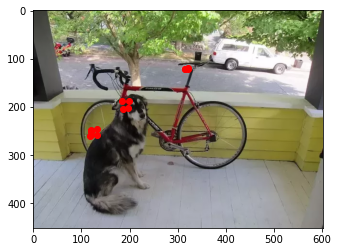

In [43]:
plt.imshow(plt.imread("images/dog-cycle-car.png"))
for x in filtered:
    plt.scatter(x[0],x[1], c='r')

In [58]:
out = write_results(
    prediction=pred,
    confidence=0.5,
    n_classes=80,
    nms_conf=0.4
)
out = np.array([corners_to_centre_dims(x) for x in out[...,1:5]])

In [59]:
out

array([[120.460526, 250.5217  , 106.57852 , 175.12695 ],
       [197.44412 , 203.02881 , 219.19646 , 173.78342 ],
       [315.57135 , 121.11572 , 110.256714,  48.690437]], dtype=float32)

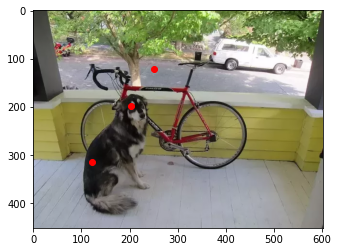

In [61]:
plt.imshow(plt.imread("images/dog-cycle-car.png"))
for x in out:
    plt.scatter(x[1],x[0], c='r')

In [ ]:
x = predict_transform(
    prediction=x, # size (n_batches, n_conv_filters_from_prev_layer, filter_w, filter_h)
    in_dims=in_dims, # model height
    anchors=anchors, # [(a1_w, a1_h), (a2_w, a2_h), (a3_w, a3_h)]
    n_classes=n_classes,
    CUDA=CUDA
)